# Using Convolutional Neural Networks

Welcome to the first week of the first deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

## Introduction to this week's task: 'Dogs vs Cats'

We're going to try to create a model to enter the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): *"**State of the art**: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. So if we can beat 80%, then we will be at the cutting edge as at 2013!

## Basic setup

There isn't too much to do to get started - just a few simple configuration steps.

This shows plots in the web page itself - we always wants to use this when using jupyter notebook:

In [1]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [2]:
#path = "data/dogsNcats/clean/"
path = "data/dogsNcats/clean/sample/"

A few basic libraries that we'll need for the initial exercises:

In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [4]:
import sys
sys.path.append('../lib')

In [5]:
import utils; reload(utils)
from utils import plots

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


# Use a pretrained VGG model with our **Vgg16** class

Our first step is simply to use a model that has been fully created for us, which can recognise a wide variety (1,000 categories) of images. We will use 'VGG', which won the 2014 Imagenet competition, and is a very simple model to create and understand. The VGG Imagenet team created both a larger, slower, slightly more accurate model (*VGG  19*) and a smaller, faster model (*VGG 16*). We will be using VGG 16 since the much slower performance of VGG19 is generally not worth the very minor improvement in accuracy.

We have created a python class, *Vgg16*, which makes using the VGG 16 model very straightforward. 

## The punchline: state of the art custom model in 7 lines of code

Here's everything you need to do to get >97% accuracy on the Dogs vs Cats dataset - we won't analyze how it works behind the scenes yet, since at this stage we're just going to focus on the minimum necessary to actually do useful work.

In [6]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

In [7]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

## Use Vgg16 for basic image recognition

Let's start off by using the *Vgg16* class to recognise the main imagenet category for each image.

We won't be able to enter the Cats vs Dogs competition with an Imagenet model alone, since 'cat' and 'dog' are not categories in Imagenet - instead each individual breed is a separate category. However, we can use it to see how well it can recognise the images, which is a good first step.

First, create a Vgg16 object:

In [8]:
vgg = Vgg16()

Vgg16 is built on top of *Keras* (which we will be learning much more about shortly!), a flexible, easy to use deep learning library that sits on top of Theano or Tensorflow. Keras reads groups of images and labels in *batches*, using a fixed directory structure, where images from each category for training must be placed in a separate folder.

Let's grab batches of data from our training folder:

In [9]:
batches = vgg.get_batches(path+'train', batch_size=4)

Found 160 images belonging to 2 classes.


(BTW, when Keras refers to 'classes', it doesn't mean python classes - but rather it refers to the categories of the labels, such as 'pug', or 'tabby'.)

*Batches* is just a regular python iterator. Each iteration returns both the images themselves, as well as the labels.

In [10]:
imgs,labels = next(batches)

As you can see, the labels for each image are an array, containing a 1 in the first position if it's a cat, and in the second position if it's a dog. This approach to encoding categorical variables, where an array containing just a single 1 in the position corresponding to the category, is very common in deep learning. It is called *one hot encoding*. 

The arrays contain two elements, because we have two categories (cat, and dog). If we had three categories (e.g. cats, dogs, and kangaroos), then the arrays would each contain two 0's, and one 1.

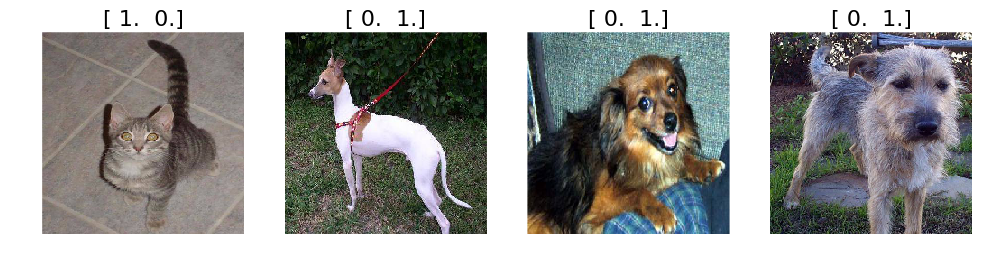

In [11]:
plots(imgs, titles=labels)

We can now pass the images to Vgg16's predict() function to get back probabilities, category indexes, and category names for each image's VGG prediction.

In [12]:
vgg.predict(imgs, True)

(array([ 0.4185,  0.6051,  0.6378,  0.359 ], dtype=float32),
 array([285, 171, 193, 182]),
 [u'Egyptian_cat',
  u'Italian_greyhound',
  u'Australian_terrier',
  u'Border_terrier'])

The category indexes are based on the ordering of categories used in the VGG model - e.g here are the first four:

In [13]:
vgg.classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

(Note that, other than creating the Vgg16 object, none of these steps are necessary to build a model; they are just showing how to use the class to view imagenet predictions.)

## Use our Vgg16 class to finetune a Dogs vs Cats model

To change our model so that it outputs "cat" vs "dog", instead of one of 1,000 very specific categories, we need to use a process called "finetuning". Finetuning looks from the outside to be identical to normal machine learning training - we provide a training set with data and labels to learn from, and a validation set to test against. The model learns a set of parameters based on the data provided.

However, the difference is that we start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very similar, or the same, between the existing model, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call *fit()* after calling *finetune()*.

We create our batches just like before, and making the validation set available as well. A 'batch' (or *mini-batch* as it is commonly known) is simply a subset of the training data - we use a subset at a time when training or predicting, in order to speed up training, and to avoid running out of memory.

In [14]:
batch_size=64

In [15]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


Calling *finetune()* modifies the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.

In [16]:
vgg.finetune(batches)

Finally, we *fit()* the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An *epoch* is one full pass through the training data.)

In [17]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
160/160 [==============================] - 6s - loss: 1.5291 - acc: 0.5875 - val_loss: 0.3579 - val_acc: 0.9000


That shows all of the steps involved in using the Vgg16 class to create an image recognition model using whatever labels you are interested in. For instance, this process could classify paintings by style, or leaves by type of disease, or satellite photos by type of crop, and so forth.

Next up, we'll dig one level deeper to see what's going on in the Vgg16 class.

## Run model through test set

In [34]:
test_path = 'data/dogsNcats/clean/'+'test'

In [23]:
test_batches, predictions = vgg.test(test_path)

Found 0 images belonging to 0 classes.


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/training.py", line 425, in data_generator_task
    generator_output = next(generator)
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/preprocessing/image.py", line 593, in next
    index_array, current_index, current_batch_size = next(self.index_generator)
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/preprocessing/image.py", line 441, in _flow_index
    current_index = (self.batch_index * batch_size) % N
ZeroDivisionError: integer division or modulo by zero



In [25]:
test_batches = vgg.get_batches(path, shuffle=False, batch_size=batch_size, class_mode=None)

Found 0 images belonging to 2 classes.


In [31]:
test_imgs = next(test_batches)

ZeroDivisionError: integer division or modulo by zero

In [30]:
vgg.predict(test_batches, True)

Exception: Error when checking : data should be a Numpy array, or list/dict of Numpy arrays. Found: <keras.preprocessing.image.DirectoryIterator object at 0x7f210f51c910>...

In [32]:
from keras.preprocessing import image

In [33]:
gen = image.ImageDataGenerator()

In [37]:
gen.flow_from_directory(test_path, target_size=(224,224),
                class_mode=None, shuffle=False, batch_size=batch_size)


Found 0 images belonging to 0 classes.
